In [2]:
from tempfile import NamedTemporaryFile
import shutil
import csv
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List
import cv2
import pandas as pd
import seaborn as sns
import yaml
import numpy as np

EXPERIMENT_FOLDER = '/home/engel/Documents/experiments/slam_experiment'
ALGORITHMS = ['cartographer', 'gmapping', 'hector', 'karto']
ARENAS = ['circular', 'point_to_point']
MAP_RESOLUTIONS = [0.05, 0.1]
LINEAR_UPDATES = [0.2, 1.0]
ANGULAR_UPDATES = [0.0174, 0.9]

### Aggregate data


In [3]:
run_table = pd.read_csv(f'{EXPERIMENT_FOLDER}/run_table.csv', sep=',',)
run_table

,__run_id,__done,algorithm,arena,map_resolution,linear_update,angular_update,repetition,avg_cpu,avg_mem,energy,rosbag_msg_count,rosbag_msg_size
0,run_1,DONE,hector,point_to_point,0.10,1.0,0.0174,1,27.367200,7.803490e+08,811694.555919,40713,3283512
1,run_2,DONE,gmapping,point_to_point,0.10,0.2,0.0174,1,39.166582,6.500988e+08,836503.353107,43282,3489688
2,run_3,DONE,cartographer,point_to_point,0.10,1.0,0.0174,1,44.676238,6.864822e+08,822121.390989,67732,4970488
3,run_4,DONE,hector,point_to_point,0.05,0.2,0.9000,1,29.950242,7.752785e+08,809836.038969,39376,3176440
4,run_5,DONE,cartographer,point_to_point,0.05,1.0,0.9000,1,43.685008,6.879992e+08,812694.845532,67045,4921248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,run_316,DONE,cartographer,circular,0.05,0.2,0.0174,5,43.735620,6.962396e+08,960621.398323,80051,5883072
316,run_317,DONE,hector,circular,0.10,0.2,0.0174,5,27.339192,7.883820e+08,936113.340140,47166,3803640
317,run_318,DONE,cartographer,circular,0.10,0.2,0.9000,5,42.169224,6.936151e+08,956718.046741,80518,5912200
318,run_319,DONE,cartographer,point_to_point,0.10,1.0,0.9000,5,39.878828,6.912402e+08,826721.375554,69730,5122048


In [42]:
with open('./run_table.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    aggregated_data = {
        'circular': {
            'cartographer': {
                'timestamp': [],
                'power_mw': [],

            },
            'gmapping': {
                'timestamp': [],
                'power_mw': [],
            },
            'hector': {
                'timestamp': [],
                'power_mw': [],
            },
            'karto': {
                'timestamp': [],
                'power_mw': [],
            },
        },
        'point_to_point': {
            'cartographer': {
                'timestamp': [],
                'power_mw': [],
            },
            'gmapping': {
                'timestamp': [],
                'power_mw': [],
            },
            'hector': {
                'timestamp': [],
                'power_mw': [],
            },
            'karto': {
                'timestamp': [],
                'power_mw': [],
            },
        },
    }

    for row in reader:
        df = pd.read_csv(f'{EXPERIMENT_FOLDER}/{row["__run_id"]}/trimmed_energy_measurements.csv', sep=',', header=None)
        df.columns = ['timestamp', 'power_mw']

        df['timestamp'] = df['timestamp'] - df['timestamp'].iat[0]
   
        aggregated_data[row["arena"]][row["algorithm"]]['timestamp'].extend(df['timestamp'].tolist())
        aggregated_data[row["arena"]][row["algorithm"]]['power_mw'].extend(df['power_mw'].divide(1000).tolist())
    

## Energy time series per algorithm

In [43]:
with open('./run_table.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    aggregated_data = {
        'circular': {
            'cartographer': {
                'timestamp': [],
                'power_mw': [],

            },
            'gmapping': {
                'timestamp': [],
                'power_mw': [],
            },
            'hector': {
                'timestamp': [],
                'power_mw': [],
            },
            'karto': {
                'timestamp': [],
                'power_mw': [],
            },
        },
        'point_to_point': {
            'cartographer': {
                'timestamp': [],
                'power_mw': [],
            },
            'gmapping': {
                'timestamp': [],
                'power_mw': [],
            },
            'hector': {
                'timestamp': [],
                'power_mw': [],
            },
            'karto': {
                'timestamp': [],
                'power_mw': [],
            },
        },
    }

    for row in reader:
        df = pd.read_csv(f'{EXPERIMENT_FOLDER}/{row["__run_id"]}/trimmed_energy_measurements.csv', sep=',', header=None)
        df.columns = ['timestamp', 'power_mw']

        df['timestamp'] = df['timestamp'] - df['timestamp'].iat[0]
   
        aggregated_data[row["arena"]][row["algorithm"]]['timestamp'].extend(df['timestamp'].tolist())
        aggregated_data[row["arena"]][row["algorithm"]]['power_mw'].extend(df['power_mw'].divide(1000).tolist())
    

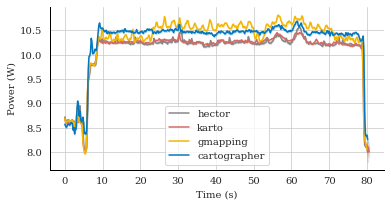

In [44]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 200

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='cartographer', color='#0477BF')

plt.legend(loc='lower center')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.savefig('energy_point_to_point_time_plot.pdf') 

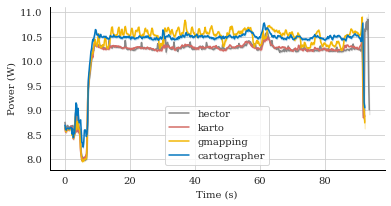

In [45]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 200

power_dataframe = pd.DataFrame(aggregated_data['circular']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['circular']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['circular']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['circular']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="power_mw", data=power_dataframe,
                  estimator="mean", label='cartographer', color='#0477BF')

plt.legend(loc='lower center')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.savefig('energy_circular_time_plot.pdf')

## CPU time series per algorithm

In [5]:
with open('./run_table.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    aggregated_data = {
        'circular': {
            'cartographer': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
            'gmapping': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
            'hector': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
            'karto': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
        },
        'point_to_point': {
            'cartographer': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
            'gmapping': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
            'hector': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
            'karto': {
                'timestamp': [],
                'cpu': [],
                'mem': [],               
            },
        },
    }

    for row in reader:
        df = pd.read_csv(f'{EXPERIMENT_FOLDER}/{row["__run_id"]}/trimmed_cpu_mem_measurements.csv', sep=',', header=None)
        df.columns = ['timestamp', 'cpu', 'mem']

        df['timestamp'] = df['timestamp'] - df['timestamp'].iat[0]
   
        aggregated_data[row["arena"]][row["algorithm"]]['timestamp'].extend(df['timestamp'].tolist())
        aggregated_data[row["arena"]][row["algorithm"]]['cpu'].extend(df['cpu'].tolist())
        aggregated_data[row["arena"]][row["algorithm"]]['mem'].extend(df['mem'].divide(1048576).tolist())
    

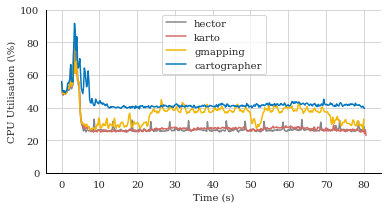

In [47]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 200

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='cartographer', color='#0477BF')

plt.ylim(0, 100)
plt.legend(loc='upper center')
plt.xlabel('Time (s)')
plt.ylabel('CPU Utilisation (\%)')
plt.savefig('cpu_point_to_point_time_plot.pdf') 

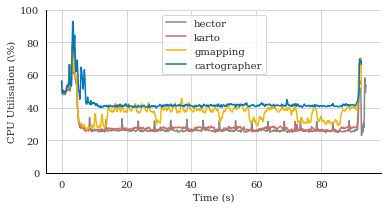

In [9]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 200

power_dataframe = pd.DataFrame(aggregated_data['circular']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['circular']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['circular']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['circular']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="cpu", data=power_dataframe,
                  estimator="mean", ci=None, label='cartographer', color='#0477BF')

plt.ylim(0, 100)
plt.legend(loc='upper center')
plt.xlabel('Time (s)')
plt.ylabel('CPU Utilisation (\%)')
plt.savefig('cpu_circular_time_plot.pdf') 

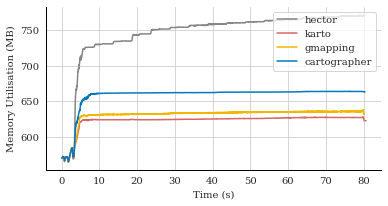

In [49]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 50

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='cartographer', color='#0477BF')

plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Memory Utilisation (MB)')
plt.savefig('mem_point_to_point_time_plot.pdf') 

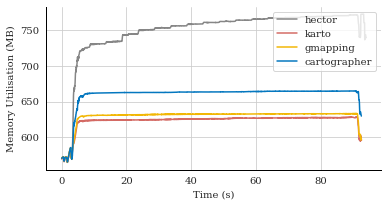

In [8]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 50

power_dataframe = pd.DataFrame(aggregated_data['circular']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['circular']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['circular']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['circular']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000

ax = sns.lineplot(x="agg_timestamp",y="mem", data=power_dataframe,
                  estimator="mean", ci=None, label='cartographer', color='#0477BF')

plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Memory Utilisation (MB)')
plt.savefig('mem_circular_time_plot.pdf') 

### Memory utilisation increase per algorithm

In [25]:
with open('./run_table.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    aggregated_data = {
        'circular': {
            'cartographer': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],        
            },
            'gmapping': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],               
            },
            'hector': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],           
            },
            'karto': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],               
            },
        },
        'point_to_point': {
            'cartographer': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],               
            },
            'gmapping': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],               
            },
            'hector': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],                
            },
            'karto': {
                'start_values': [],
                'end_values': [],
                'increase_values': [],                 
            },
        },
    }

    for row in reader:
        df = pd.read_csv(f'{EXPERIMENT_FOLDER}/{row["__run_id"]}/trimmed_cpu_mem_measurements.csv', sep=',', header=None)
        df.columns = ['timestamp', 'cpu', 'mem']
        df['timestamp'] = df['timestamp'] - df['timestamp'].iat[0]

        if row["arena"] == 'point_to_point':
            df = df[(df['timestamp'] >= 5670) & (df['timestamp'] <= 78878)]
        elif row["arena"] == 'circular':
            df = df[(df['timestamp'] >= 6682) & (df['timestamp'] <= 91035)] 
   
        aggregated_data[row["arena"]][row["algorithm"]]['start_values'].extend([df['mem'].iat[0] / 1048576])
        aggregated_data[row["arena"]][row["algorithm"]]['end_values'].extend([df['mem'].iat[-1] / 1048576])
        aggregated_data[row["arena"]][row["algorithm"]]['increase_values'].extend([df['mem'].iat[-1] / df['mem'].iat[0] - 1])
        
    for arena in ARENAS:
        print(f'==== {arena} ====')
        for algorithm in ALGORITHMS:
            mean_start = sum(aggregated_data[arena][algorithm]['start_values']) / len(aggregated_data[arena][algorithm]['start_values'])
            mean_end = sum(aggregated_data[arena][algorithm]['end_values']) / len(aggregated_data[arena][algorithm]['end_values'])
            mean_increase = sum(aggregated_data[arena][algorithm]['increase_values']) / len(aggregated_data[arena][algorithm]['increase_values'])
            print(f'{algorithm}: {mean_start} -> {mean_end} (diff {mean_end - mean_start}, +{mean_end / mean_start -1}) reference: {mean_increase}')

==== circular ====
cartographer: 657.567578125 -> 664.2515625 (diff 6.683984375000023, +0.010164710970177238) reference: 0.01049027590114201
gmapping: 628.58369140625 -> 632.97138671875 (diff 4.3876953125, +0.006980288181966721) reference: 0.0070739995033873735
hector: 722.8759765625 -> 771.80205078125 (diff 48.926074218750045, +0.06768252896078897) reference: 0.0685843697873466
karto: 622.117578125 -> 627.14560546875 (diff 5.0280273437499545, +0.00808211746548615) reference: 0.008142919609021634
==== point_to_point ====
cartographer: 652.1205078125 -> 663.773046875 (diff 11.652539062499955, +0.017868689794142023) reference: 0.01846781325818935
gmapping: 629.63349609375 -> 635.74423828125 (diff 6.110742187500023, +0.009705236816991425) reference: 0.009673356239824776
hector: 723.1474609375 -> 770.35947265625 (diff 47.21201171874998, +0.06528683881091624) reference: 0.06536409276694535
karto: 623.51259765625 -> 627.2033203125 (diff 3.690722656249932, +0.005919243123752693) reference: 0.

## Message count over time

In [53]:
with open('./run_table.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    aggregated_data = {
        'circular': {
            'cartographer': {
                'timestamp': [],
                'topic': [],
                'size': [],               
            },
            'gmapping': {
                'timestamp': [],
                'topic': [],
                'size': [],                     
            },
            'hector': {
                'timestamp': [],
                'topic': [],
                'size': [],                   
            },
            'karto': {
                'timestamp': [],
                'topic': [],
                'size': [],                     
            },
        },
        'point_to_point': {
            'cartographer': {
                'timestamp': [],
                'topic': [],
                'size': [],                  
            },
            'gmapping': {
                'timestamp': [],
                'topic': [],
                'size': [],                    
            },
            'hector': {
                'timestamp': [],
                'topic': [],
                'size': [],                      
            },
            'karto': {
                'timestamp': [],
                'topic': [],
                'size': [],                    
            },
        },
    }

    for row in reader:
        df = pd.read_csv(f'{EXPERIMENT_FOLDER}/{row["__run_id"]}/rosbag_measurements.csv', sep=',', header=None)
        df.columns = ['timestamp', 'topic', 'size']

        df['timestamp'] = df['timestamp'] - df['timestamp'].iat[0]
   
        aggregated_data[row["arena"]][row["algorithm"]]['timestamp'].extend(df['timestamp'].tolist())
        aggregated_data[row["arena"]][row["algorithm"]]['topic'].extend(df['topic'].tolist())
        aggregated_data[row["arena"]][row["algorithm"]]['size'].extend(df['size'].tolist())
    

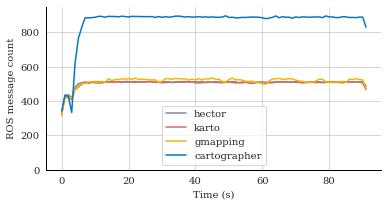

In [73]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 1000

power_dataframe = pd.DataFrame(aggregated_data['circular']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator="mean", ci=None, label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['circular']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator='mean', ci=None, label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['circular']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator='mean', ci=None, label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['circular']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator='mean', ci=None, label='cartographer', color='#0477BF')

plt.legend(loc='lower center')
plt.xlabel('Time (s)')
plt.ylabel('ROS messages / second')
plt.ylim(0, 950)
plt.savefig('ros_message_count_circular_time_plot.pdf')

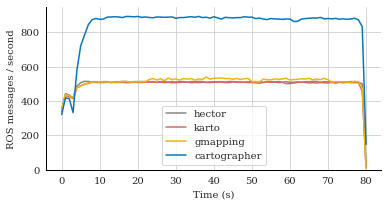

In [74]:
fix, ax = plt.subplots(figsize=(6, 3))
sns.set_style("whitegrid")
sns.despine()
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_color('black')
ax.spines["left"].set_linewidth(1)
ax.spines["left"].set_color('black')

plt.rcParams["font.family"] = "serif"
agg_factor = 1000

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['hector'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator="mean", ci=None, label='hector', color='#868686')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['karto'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator='mean', ci=None, label='karto', color='#D46A64')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['gmapping'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator='mean', ci=None, label='gmapping', color='#F2B705')

power_dataframe = pd.DataFrame(aggregated_data['point_to_point']['cartographer'])
power_dataframe.sort_values('timestamp', axis=0, ascending=True, inplace=True)
power_dataframe['agg_timestamp'] = (power_dataframe['timestamp'] - (power_dataframe['timestamp'] % agg_factor)) /1000
counts = power_dataframe.groupby('agg_timestamp').count()
power_dataframe['count'] = [counts['timestamp'][timestamp_val] / 40 for timestamp_val in power_dataframe['agg_timestamp']]

ax = sns.lineplot(x="agg_timestamp",y="count", data=power_dataframe[power_dataframe['agg_timestamp'] < 92],
                  estimator='mean', ci=None, label='cartographer', color='#0477BF')

plt.legend(loc='lower center')
plt.xlabel('Time (s)')
plt.ylabel('ROS messages / second')
plt.ylim(0, 950)
plt.savefig('ros_message_count_point_to_point_time_plot.pdf')